# Preprocessing

## biomass_history

In [129]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,Input,LSTM, Flatten, ConvLSTM2D
from tensorflow.keras.models import Sequential,Model
from sklearn.metrics import mean_squared_error

In [2]:
biomass_history = pd.read_csv('dataset\Biomass_History.csv')

In [3]:
#Check if there are any null values
biomass_history .isnull().sum()

Index        0
Latitude     0
Longitude    0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
dtype: int64

In [4]:
biomass_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      2418 non-null   int64  
 1   Latitude   2418 non-null   float64
 2   Longitude  2418 non-null   float64
 3   2010       2418 non-null   float64
 4   2011       2418 non-null   float64
 5   2012       2418 non-null   float64
 6   2013       2418 non-null   float64
 7   2014       2418 non-null   float64
 8   2015       2418 non-null   float64
 9   2016       2418 non-null   float64
 10  2017       2418 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 207.9 KB


<AxesSubplot: xlabel='2010', ylabel='Count'>

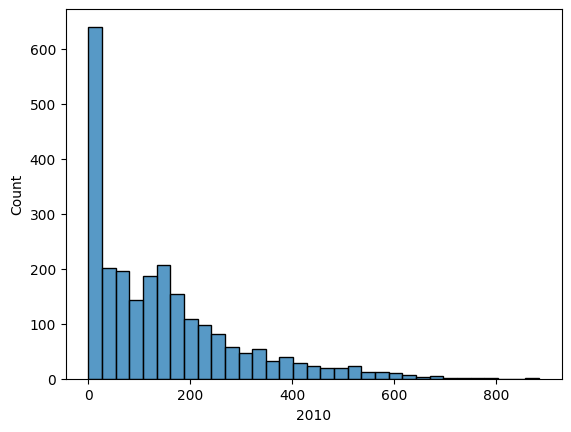

In [5]:
# df.head()
sns.histplot(biomass_history,x='2010')

In [6]:
#converting float64 to float32 and int64 to int16
columns = list(biomass_history.columns)
for column in columns:
    if(type(biomass_history[column][0]) == np.float64):
        biomass_history[column] = biomass_history[column].astype('float16')
    if(type(biomass_history[column][0]) == np.int64):
        biomass_history[column] = biomass_history[column].astype('int16')
        

In [7]:
biomass_history.head()

,Index,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017
0,0,24.671875,71.3125,8.476562,8.867188,9.203125,6.023438,10.789062,6.648438,7.386719,5.179688
1,1,24.671875,71.4375,24.031250,28.546875,25.859375,21.640625,34.406250,27.359375,40.437500,42.125000
2,2,24.671875,71.5000,44.843750,66.125000,56.968750,53.000000,70.937500,42.531250,59.187500,73.187500
3,3,24.671875,71.5625,59.968750,80.812500,78.937500,63.156250,93.500000,70.187500,74.562500,101.062500
4,4,24.671875,71.6250,14.656250,19.328125,21.921875,17.906250,19.531250,19.171875,16.531250,26.093750


In [8]:
#Scaling the columns from 2010 to 2017

ct = ColumnTransformer([('std',MinMaxScaler(),[str(x) for x in np.arange(2010,2018)]),
                       ],remainder='passthrough')

In [9]:
transformed_df = ct.fit_transform(biomass_history)

In [10]:
transformed_df= pd.DataFrame(transformed_df,columns=['2010','2011','2012','2013' ,'2014','2015','2016','2017','Index','Latitude','Longitude'])

In [11]:
transformed_df = transformed_df[columns]

<AxesSubplot: xlabel='2010', ylabel='Count'>

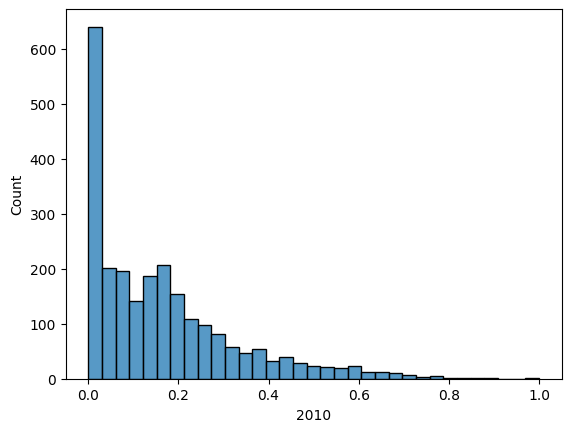

In [12]:
sns.histplot(transformed_df, x='2010')

In [13]:
biomass_history_scaled = transformed_df.copy()

,Index,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017
0,0.0,24.671875,71.3125,0.009598,0.011497,0.010551,0.004887,0.012367,0.008621,0.014374,0.005863


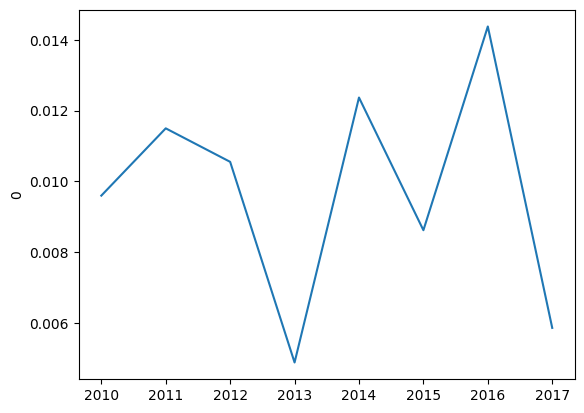

In [14]:
#how does the biomass history look like for a particualr coordinate
#24.671875,71.3125
df = biomass_history_scaled.loc[(biomass_history_scaled['Latitude']==24.671875) & (biomass_history_scaled['Longitude']==71.3125)]
# sns.lineplot(data=df.iloc[0,3:], x=[str(x) for x in np.arange(2010,2018)])
sns.lineplot(x=[str(x) for x in np.arange(2010,2018)], y=df.iloc[0,3:])
df

## Distance

In [15]:
distance_matrix = pd.read_csv('dataset\Distance_Matrix.csv')
distance_matrix.drop(['Unnamed: 0'],axis=1,inplace=True)

<AxesSubplot: xlabel='1', ylabel='Count'>

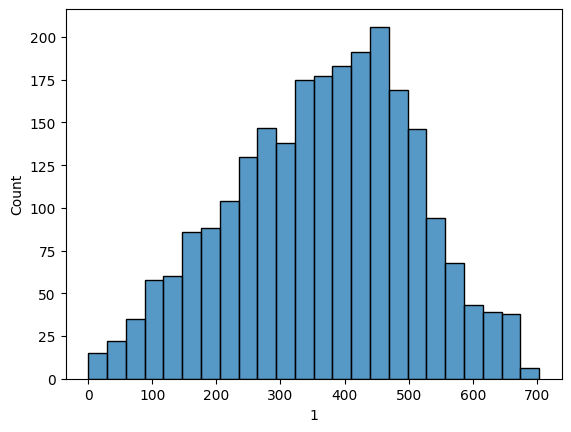

In [16]:
sns.histplot(distance_matrix,x='1')

In [17]:
scaler_mms = MinMaxScaler()
scaled_distances = pd.DataFrame(scaler_mms.fit_transform(distance_matrix),
                                 columns = distance_matrix.columns)

<AxesSubplot: xlabel='1', ylabel='Count'>

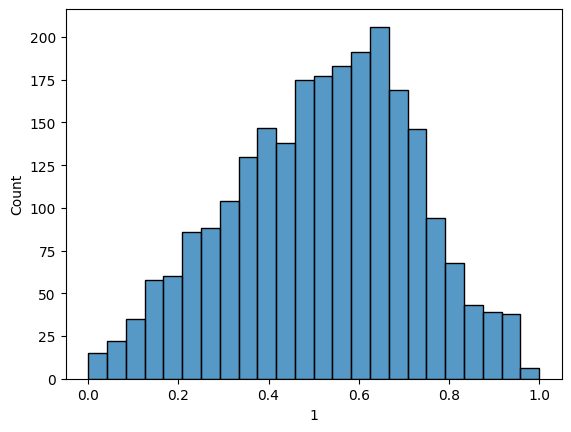

In [18]:
sns.histplot(scaled_distances,x='1')

# Some important functions

In [19]:
#get distance between two coordinates
def distance_bw_coordinates(x1,y1,x2,y2):
    point1 = biomass_history_scaled.loc[(biomass_history_scaled['Latitude']==x1) & (biomass_history_scaled['Longitude']==y1)].index[0]
    point2 = biomass_history_scaled.loc[(biomass_history_scaled['Latitude']==x2) & (biomass_history_scaled['Longitude']==y2)].index[0]
    return scaled_distances.iloc[point1,point2]
# distance_bw_coordinates(24.671875,71.3125,24.671875,71.4375)
# 0.01617031498066282

In [20]:
#get the biomass history at a particular coordinate
def get_biomass_hist_scaled(x,y,year=None,data=biomass_history_scaled):
    if(year!=None):
        return data.loc[(data['Latitude']==x) & (data['Longitude']==y), str(year)][0]
    else:
        return data.loc[(data['Latitude']==x) & (data['Longitude']==y)]
# get_biomass_hist_scaled(24.671875,71.3125,2010)
# 0.009597778

# Splitting into train and test data

In [21]:
test_df,train_df = biomass_history_scaled,biomass_history_scaled.drop(['2017'],axis=1)

In [22]:
#for a particular coordinate this gives the train and the test data
#x and y are the latitude and longitude and n is the number of dataset for train set
#this will create batches of dataset
def data_batch_generator(x,y,n=1,data=train_df):
    data_x=[]
    data_y=[]
    data=np.array(get_biomass_hist_scaled(x,y,data=data))[0][3:]
    xi=[]
    yi=[]
    test = test_df.iloc[:,-n-1:]
    test_df_x = test.iloc[:,:-1]
    test_df_y = test.iloc[:,-1]
    idx = biomass_history_scaled.loc[(biomass_history_scaled['Latitude']==x) & (biomass_history_scaled['Longitude']==y)].index[0]
    test_df_x = np.array(test_df_x.iloc[idx])
    test_df_y = np.array(test_df_y.iloc[idx])
    for i in range(len(data)-n+1):
        try:
            xi = data[i:i+n]
            yi = data[i+n]
            data_x.append(xi)
            data_y.append(yi)
            
        except:
            print("Data generation Successful")
    return np.array(data_x),np.array(data_y),np.array([test_df_x]),test_df_y.reshape(-1)

# data_batch_generator(24.671875,71.3125,3)
# ([array([0.00959778, 0.0114975 , 0.01055145], dtype=float32),
#   array([0.0114975 , 0.01055145, 0.00488663], dtype=float32),
#   array([0.01055145, 0.00488663, 0.01236725], dtype=float32),
#   array([0.00488663, 0.01236725, 0.00862122], dtype=float32)],
#  [array(0.00488663, dtype=float32),
#   array(0.01236725, dtype=float32),
#   array(0.00862122, dtype=float32),
#   array(0.01437378, dtype=float32)],
#  array([0.01236725, 0.00862122, 0.01437378], dtype=float32),
#  array(0.00586319, dtype=float32))


In [23]:
#for coordinates 24.671875,71.3125
train_x,train_y,test_x,test_y = data_batch_generator(24.671875,71.3125,4)

Data generation Successful


In [24]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3, 4)
(3,)
(1, 4)
(1,)


# DNN

In [89]:
input_layer = Input(shape=(4,),name='input')
dense_layer = Dense(units=32,activation='relu',name='d1')(input_layer)
dense_layer = Dense(units=64, activation='relu',name='d2')(input_layer)
dense_layer = Dense(units=128, activation='relu',name='d3')(dense_layer)
dense_layer = Dense(units=256, activation='relu',name='d4')(dense_layer)
dense_layer = Dense(units=512, activation='relu',name='d5')(dense_layer)
dense_layer = Dense(units=1024, activation='relu',name='d6')(dense_layer)
dense_layer = Dense(units=256, activation='relu',name='d7')(dense_layer)
output_layer = Dense(units=1, activation='linear',name='output')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [90]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 d2 (Dense)                  (None, 64)                320       
                                                                 
 d3 (Dense)                  (None, 128)               8320      
                                                                 
 d4 (Dense)                  (None, 256)               33024     
                                                                 
 d5 (Dense)                  (None, 512)               131584    
                                                                 
 d6 (Dense)                  (None, 1024)              525312    
                                                                 
 d7 (Dense)                  (None, 256)               262

In [91]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),verbose=2,epochs=100)

Epoch 1/100
1/1 - 1s - loss: 1.4143e-04 - accuracy: 0.0000e+00 - val_loss: 1.2188e-04 - val_accuracy: 0.0000e+00 - 907ms/epoch - 907ms/step
Epoch 2/100
1/1 - 0s - loss: 3.0695e-05 - accuracy: 0.0000e+00 - val_loss: 5.3527e-05 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 3/100
1/1 - 0s - loss: 7.2827e-06 - accuracy: 0.0000e+00 - val_loss: 6.7517e-06 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 4/100
1/1 - 0s - loss: 1.7010e-05 - accuracy: 0.0000e+00 - val_loss: 4.8359e-05 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 5/100
1/1 - 0s - loss: 6.4936e-06 - accuracy: 0.0000e+00 - val_loss: 7.2305e-05 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 6/100
1/1 - 0s - loss: 1.2220e-05 - accuracy: 0.0000e+00 - val_loss: 2.5373e-05 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 7/100
1/1 - 0s - loss: 6.0793e-06 - accuracy: 0.0000e+00 - val_loss: 1.2598e-05 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
Epoch 8/100
1/1 - 0s - loss: 1.0

In [103]:
prediction = model.predict(test_x)

1/1 [==============================] - 0s 16ms/step


In [123]:
inverse_transformed_prediction = ct.named_transformers_['std'].inverse_transform(
     np.hstack([get_biomass_hist_scaled(24.671875,71.3125).iloc[:,3:-1],prediction])
)

In [125]:
inverse_transformed_prediction

array([[ 8.478675 ,  8.86512  ,  9.204971 ,  6.0252056, 10.788841 ,
         6.6471505,  7.3883886,  6.9177217]], dtype=float32)

# LSTM

In [228]:
# input_layer = Input(shape=(4,),name='input')
# dense_layer = LSTM(64,name='lstm',input_shape=(None,4))(input_layer)
# dense_layer = Dense(32,name='d1')(dese_layer)
# output_layer = Dense(1,name='output')(dese_layer)
# model = Model(inputs=input_layer, outputs=output_layer)
model=Sequential()
model.add(LSTM(64,input_shape=(None,4)))
model.add(Dense(32))
# model.add(Dense(256))
# model.add(Dense(16))
# model.add(Dense(64))
# model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 64)                17664     
                                                                 
 dense_47 (Dense)            (None, 32)                2080      
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


In [229]:
trainX = np.reshape(train_x,(train_x.shape[0],1,train_x.shape[1]))    
testX = np.reshape(test_x,(test_x.shape[0],1,test_x.shape[1]))

In [230]:
model.fit(trainX,train_y,validation_data=(testX,test_y),verbose=2,epochs=100)

Epoch 1/100
1/1 - 2s - loss: 1.5194e-04 - val_loss: 2.5448e-05 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 6.3836e-06 - val_loss: 1.7324e-04 - 23ms/epoch - 23ms/step
Epoch 3/100
1/1 - 0s - loss: 6.0854e-05 - val_loss: 2.1372e-04 - 25ms/epoch - 25ms/step
Epoch 4/100
1/1 - 0s - loss: 8.4594e-05 - val_loss: 1.4633e-04 - 28ms/epoch - 28ms/step
Epoch 5/100
1/1 - 0s - loss: 4.6271e-05 - val_loss: 6.3014e-05 - 36ms/epoch - 36ms/step
Epoch 6/100
1/1 - 0s - loss: 1.0706e-05 - val_loss: 1.3777e-05 - 27ms/epoch - 27ms/step
Epoch 7/100
1/1 - 0s - loss: 9.8330e-06 - val_loss: 4.8156e-07 - 28ms/epoch - 28ms/step
Epoch 8/100
1/1 - 0s - loss: 3.0942e-05 - val_loss: 1.7525e-07 - 29ms/epoch - 29ms/step
Epoch 9/100
1/1 - 0s - loss: 4.3240e-05 - val_loss: 7.8391e-08 - 28ms/epoch - 28ms/step
Epoch 10/100
1/1 - 0s - loss: 3.5110e-05 - val_loss: 5.0962e-06 - 26ms/epoch - 26ms/step
Epoch 11/100
1/1 - 0s - loss: 1.7549e-05 - val_loss: 2.3583e-05 - 27ms/epoch - 27ms/step
Epoch 12/100
1/1 - 0s - loss: 6.39

In [231]:
prediction = model.predict(testX)

1/1 [==============================] - 0s 260ms/step


In [232]:
inverse_transformed_prediction = ct.named_transformers_['std'].inverse_transform(
     np.hstack([get_biomass_hist_scaled(24.671875,71.3125).iloc[:,3:-1],prediction])
)

In [233]:
inverse_transformed_prediction

array([[ 8.478675 ,  8.86512  ,  9.204971 ,  6.0252056, 10.788841 ,
         6.6471505,  7.3883886,  9.492224 ]], dtype=float32)